In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [1]:
import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)

import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)


new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# Reset index for the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

pd.set_option('display.max_columns', None)  

df = df[~df.isin(['x']).any(axis=1)]

one_hot_encoded_data = pd.get_dummies(df, columns = ['Digester', 'Source', 'Type', 'Waste', 'Biomass']).astype(int)
# print(one_hot_encoded_data)
df_use = one_hot_encoded_data


## Base Model

### No CV

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset from DataFrame
def prepare_data(df, target_column):
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, df, target_column):
        X, y = prepare_data(df, target_column)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    mse_loss = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = mse_loss(predictions, y_batch)
            total_loss += loss.item()
    print(f"Test MSE Loss: {total_loss/len(test_loader):.4f}")

# Sample data (replace with your actual DataFrame)
df = pd.read_csv("Data/New_Data.csv")  # Load your dataset

target_column = "ACE-km"  # Define the target column
train_size = int(0.8 * len(df))
train_df = df_use[:train_size]
test_df = df_use[train_size:]

# Create datasets and data loaders
train_dataset = MicrobialDataset(train_df, target_column)
test_dataset = MicrobialDataset(test_df, target_column)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_df.shape[1] - 1  # Number of features
model = TransformerRegressionModel(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, device, epochs=50)
evaluate_model(model, test_loader, device)


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50], Loss: 249.5402
Epoch [2/50], Loss: 182.2895
Epoch [3/50], Loss: 171.2503
Epoch [4/50], Loss: 131.8796
Epoch [5/50], Loss: 171.4570
Epoch [6/50], Loss: 150.2130
Epoch [7/50], Loss: 164.2311
Epoch [8/50], Loss: 151.8343
Epoch [9/50], Loss: 152.8200
Epoch [10/50], Loss: 176.5534
Epoch [11/50], Loss: 153.3517
Epoch [12/50], Loss: 138.5383
Epoch [13/50], Loss: 155.9194
Epoch [14/50], Loss: 119.9991
Epoch [15/50], Loss: 129.6535
Epoch [16/50], Loss: 126.8164
Epoch [17/50], Loss: 144.9069
Epoch [18/50], Loss: 137.4190
Epoch [19/50], Loss: 127.4180
Epoch [20/50], Loss: 111.3035
Epoch [21/50], Loss: 120.6378
Epoch [22/50], Loss: 136.5822
Epoch [23/50], Loss: 125.1203
Epoch [24/50], Loss: 115.7630
Epoch [25/50], Loss: 128.2270
Epoch [26/50], Loss: 134.8051
Epoch [27/50], Loss: 103.0411
Epoch [28/50], Loss: 123.5336
Epoch [29/50], Loss: 137.4987
Epoch [30/50], Loss: 106.1658
Epoch [31/50], Loss: 108.5831
Epoch [32/50], Loss: 128.9393
Epoch [33/50], Loss: 122.4721
Epoch [34/50], Loss

### 5-Fold CV

Fold 1/5
Epoch [1/100], Loss: 238.1808
Epoch [2/100], Loss: 176.5608
Epoch [3/100], Loss: 156.5747
Epoch [4/100], Loss: 157.5534
Epoch [5/100], Loss: 167.2580
Epoch [6/100], Loss: 175.5359
Epoch [7/100], Loss: 170.8079
Epoch [8/100], Loss: 126.9103
Epoch [9/100], Loss: 159.2452
Epoch [10/100], Loss: 148.2066


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [11/100], Loss: 120.4725
Epoch [12/100], Loss: 125.1022
Epoch [13/100], Loss: 117.0448
Epoch [14/100], Loss: 108.4766
Epoch [15/100], Loss: 138.3530
Epoch [16/100], Loss: 133.7853
Epoch [17/100], Loss: 133.6639
Epoch [18/100], Loss: 144.6780
Epoch [19/100], Loss: 119.2892
Epoch [20/100], Loss: 114.7506
Epoch [21/100], Loss: 143.2523
Epoch [22/100], Loss: 132.1525
Epoch [23/100], Loss: 113.7362
Epoch [24/100], Loss: 116.8167
Epoch [25/100], Loss: 107.4339
Epoch [26/100], Loss: 117.4850
Epoch [27/100], Loss: 100.7172
Epoch [28/100], Loss: 141.3075
Epoch [29/100], Loss: 131.1488
Epoch [30/100], Loss: 128.6923
Epoch [31/100], Loss: 125.7288
Epoch [32/100], Loss: 112.3759
Epoch [33/100], Loss: 108.9257
Epoch [34/100], Loss: 99.0423
Epoch [35/100], Loss: 99.6177
Epoch [36/100], Loss: 110.2022
Epoch [37/100], Loss: 106.2557
Epoch [38/100], Loss: 95.7192
Epoch [39/100], Loss: 108.1756
Epoch [40/100], Loss: 121.6559
Epoch [41/100], Loss: 95.8199
Epoch [42/100], Loss: 120.1204
Epoch [43/10

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/100], Loss: 145.4388
Epoch [11/100], Loss: 134.1069
Epoch [12/100], Loss: 128.5184
Epoch [13/100], Loss: 140.5785
Epoch [14/100], Loss: 130.9865
Epoch [15/100], Loss: 111.8498
Epoch [16/100], Loss: 112.4445
Epoch [17/100], Loss: 121.7905
Epoch [18/100], Loss: 104.3625
Epoch [19/100], Loss: 118.8215
Epoch [20/100], Loss: 119.8123
Epoch [21/100], Loss: 98.6462
Epoch [22/100], Loss: 107.1371
Epoch [23/100], Loss: 101.0577
Epoch [24/100], Loss: 132.0947
Epoch [25/100], Loss: 124.7626
Epoch [26/100], Loss: 108.7583
Epoch [27/100], Loss: 120.8348
Epoch [28/100], Loss: 99.2602
Epoch [29/100], Loss: 90.9467
Epoch [30/100], Loss: 110.2077
Epoch [31/100], Loss: 102.0060
Epoch [32/100], Loss: 106.0666
Epoch [33/100], Loss: 116.7716
Epoch [34/100], Loss: 82.3677
Epoch [35/100], Loss: 84.8640
Epoch [36/100], Loss: 74.5087
Epoch [37/100], Loss: 72.8899
Epoch [38/100], Loss: 98.5629
Epoch [39/100], Loss: 94.1863
Epoch [40/100], Loss: 69.1894
Epoch [41/100], Loss: 71.4606
Epoch [42/100], Los

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [9/100], Loss: 152.9023
Epoch [10/100], Loss: 129.1934
Epoch [11/100], Loss: 137.6217
Epoch [12/100], Loss: 130.7216
Epoch [13/100], Loss: 161.0319
Epoch [14/100], Loss: 129.3385
Epoch [15/100], Loss: 124.8813
Epoch [16/100], Loss: 132.2075
Epoch [17/100], Loss: 115.5376
Epoch [18/100], Loss: 117.7805
Epoch [19/100], Loss: 140.8043
Epoch [20/100], Loss: 135.9319
Epoch [21/100], Loss: 112.3929
Epoch [22/100], Loss: 133.4423
Epoch [23/100], Loss: 125.1042
Epoch [24/100], Loss: 100.4411
Epoch [25/100], Loss: 115.1026
Epoch [26/100], Loss: 133.7503
Epoch [27/100], Loss: 131.3440
Epoch [28/100], Loss: 113.6654
Epoch [29/100], Loss: 104.1160
Epoch [30/100], Loss: 107.1063
Epoch [31/100], Loss: 126.5838
Epoch [32/100], Loss: 103.0228
Epoch [33/100], Loss: 102.3174
Epoch [34/100], Loss: 117.7142
Epoch [35/100], Loss: 116.1181
Epoch [36/100], Loss: 126.1557
Epoch [37/100], Loss: 112.2126
Epoch [38/100], Loss: 97.5309
Epoch [39/100], Loss: 112.6258
Epoch [40/100], Loss: 105.8921
Epoch [41/

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100], Loss: 219.4329
Epoch [2/100], Loss: 152.2266
Epoch [3/100], Loss: 136.8840
Epoch [4/100], Loss: 147.5929
Epoch [5/100], Loss: 141.0299
Epoch [6/100], Loss: 121.5162
Epoch [7/100], Loss: 113.6887
Epoch [8/100], Loss: 126.7374
Epoch [9/100], Loss: 140.8054
Epoch [10/100], Loss: 97.0071
Epoch [11/100], Loss: 120.9480
Epoch [12/100], Loss: 145.8096
Epoch [13/100], Loss: 104.1878
Epoch [14/100], Loss: 107.6653
Epoch [15/100], Loss: 137.5069
Epoch [16/100], Loss: 97.8253
Epoch [17/100], Loss: 125.1268
Epoch [18/100], Loss: 132.3521
Epoch [19/100], Loss: 127.6622
Epoch [20/100], Loss: 127.9230
Epoch [21/100], Loss: 127.2261
Epoch [22/100], Loss: 106.5207
Epoch [23/100], Loss: 107.2032
Epoch [24/100], Loss: 94.8337
Epoch [25/100], Loss: 96.8975
Epoch [26/100], Loss: 96.1797
Epoch [27/100], Loss: 115.3983
Epoch [28/100], Loss: 89.6379
Epoch [29/100], Loss: 114.2249
Epoch [30/100], Loss: 114.3484
Epoch [31/100], Loss: 94.1517
Epoch [32/100], Loss: 95.4581
Epoch [33/100], Loss: 83.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [6/100], Loss: 103.0867
Epoch [7/100], Loss: 122.9314
Epoch [8/100], Loss: 117.1385
Epoch [9/100], Loss: 115.4375
Epoch [10/100], Loss: 101.1121
Epoch [11/100], Loss: 89.3370
Epoch [12/100], Loss: 98.5043
Epoch [13/100], Loss: 101.9020
Epoch [14/100], Loss: 83.2457
Epoch [15/100], Loss: 87.3978
Epoch [16/100], Loss: 75.1025
Epoch [17/100], Loss: 87.0224
Epoch [18/100], Loss: 87.6564
Epoch [19/100], Loss: 75.7465
Epoch [20/100], Loss: 79.7729
Epoch [21/100], Loss: 73.6538
Epoch [22/100], Loss: 91.7034
Epoch [23/100], Loss: 84.1714
Epoch [24/100], Loss: 85.6383
Epoch [25/100], Loss: 88.8065
Epoch [26/100], Loss: 90.2743
Epoch [27/100], Loss: 78.0667
Epoch [28/100], Loss: 88.5324
Epoch [29/100], Loss: 76.9079
Epoch [30/100], Loss: 82.7719
Epoch [31/100], Loss: 92.8133
Epoch [32/100], Loss: 96.2540
Epoch [33/100], Loss: 76.1081
Epoch [34/100], Loss: 97.6464
Epoch [35/100], Loss: 80.6375
Epoch [36/100], Loss: 94.1942
Epoch [37/100], Loss: 73.7847
Epoch [38/100], Loss: 85.0417
Epoch [3

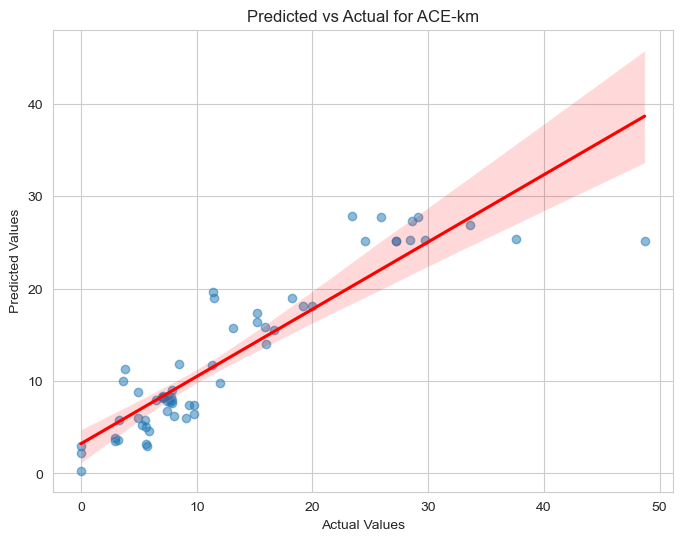

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset from DataFrame
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=16, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Cross-validation function
def cross_validate(df, target_column, k_folds=5, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k_folds}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                val_preds.extend(predictions)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        print(f"Fold {fold+1}: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"Final Cross-Validation Results: MSE = {np.mean(mse_scores):.4f}, R^2 = {np.mean(r2_scores):.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform cross-validation for a target column
target_column = "ACE-km"
cross_validate(df, target_column)


Fold 1/5
Epoch [1/100], Loss: 238.2786
Epoch [2/100], Loss: 169.1809
Epoch [3/100], Loss: 184.4600
Epoch [4/100], Loss: 163.6804
Epoch [5/100], Loss: 151.7298
Epoch [6/100], Loss: 146.4829
Epoch [7/100], Loss: 165.6030
Epoch [8/100], Loss: 154.9641
Epoch [9/100], Loss: 116.5766
Epoch [10/100], Loss: 150.1086


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [11/100], Loss: 177.8302
Epoch [12/100], Loss: 125.3276
Epoch [13/100], Loss: 144.5401
Epoch [14/100], Loss: 156.5723
Epoch [15/100], Loss: 127.0285
Epoch [16/100], Loss: 153.6550
Epoch [17/100], Loss: 138.6663
Epoch [18/100], Loss: 137.7980
Epoch [19/100], Loss: 138.6865
Epoch [20/100], Loss: 152.3131
Epoch [21/100], Loss: 121.4910
Epoch [22/100], Loss: 109.7403
Epoch [23/100], Loss: 136.5576
Epoch [24/100], Loss: 111.9325
Epoch [25/100], Loss: 132.2966
Epoch [26/100], Loss: 122.5877
Epoch [27/100], Loss: 130.5868
Epoch [28/100], Loss: 128.5789
Epoch [29/100], Loss: 132.2475
Epoch [30/100], Loss: 109.3085
Epoch [31/100], Loss: 122.8684
Epoch [32/100], Loss: 101.4562
Epoch [33/100], Loss: 116.0082
Epoch [34/100], Loss: 123.1167
Epoch [35/100], Loss: 112.8298
Epoch [36/100], Loss: 108.8824
Epoch [37/100], Loss: 117.5599
Epoch [38/100], Loss: 106.5300
Epoch [39/100], Loss: 115.3471
Epoch [40/100], Loss: 106.9404
Epoch [41/100], Loss: 133.7758
Epoch [42/100], Loss: 130.0946
Epoch [4

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/100], Loss: 169.5875
Epoch [8/100], Loss: 124.5226
Epoch [9/100], Loss: 134.7316
Epoch [10/100], Loss: 160.6457
Epoch [11/100], Loss: 127.8248
Epoch [12/100], Loss: 149.6157
Epoch [13/100], Loss: 106.3198
Epoch [14/100], Loss: 128.5958
Epoch [15/100], Loss: 121.5677
Epoch [16/100], Loss: 148.0456
Epoch [17/100], Loss: 116.5908
Epoch [18/100], Loss: 111.0045
Epoch [19/100], Loss: 116.1016
Epoch [20/100], Loss: 124.6410
Epoch [21/100], Loss: 120.7796
Epoch [22/100], Loss: 109.4841
Epoch [23/100], Loss: 122.8428
Epoch [24/100], Loss: 103.8637
Epoch [25/100], Loss: 116.4005
Epoch [26/100], Loss: 104.3111
Epoch [27/100], Loss: 129.5189
Epoch [28/100], Loss: 123.9738
Epoch [29/100], Loss: 106.5469
Epoch [30/100], Loss: 103.4571
Epoch [31/100], Loss: 118.1911
Epoch [32/100], Loss: 89.2322
Epoch [33/100], Loss: 116.4855
Epoch [34/100], Loss: 87.3908
Epoch [35/100], Loss: 96.2158
Epoch [36/100], Loss: 97.3369
Epoch [37/100], Loss: 94.5330
Epoch [38/100], Loss: 87.0967
Epoch [39/100], L

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [8/100], Loss: 146.7071
Epoch [9/100], Loss: 150.2779
Epoch [10/100], Loss: 135.8591
Epoch [11/100], Loss: 147.4140
Epoch [12/100], Loss: 135.5543
Epoch [13/100], Loss: 154.1634
Epoch [14/100], Loss: 121.1714
Epoch [15/100], Loss: 116.2016
Epoch [16/100], Loss: 128.3818
Epoch [17/100], Loss: 122.3728
Epoch [18/100], Loss: 132.3987
Epoch [19/100], Loss: 151.4215
Epoch [20/100], Loss: 113.3835
Epoch [21/100], Loss: 134.0097
Epoch [22/100], Loss: 135.7180
Epoch [23/100], Loss: 129.0506
Epoch [24/100], Loss: 119.6333
Epoch [25/100], Loss: 135.2792
Epoch [26/100], Loss: 104.3027
Epoch [27/100], Loss: 111.3158
Epoch [28/100], Loss: 121.8571
Epoch [29/100], Loss: 107.5517
Epoch [30/100], Loss: 113.1316
Epoch [31/100], Loss: 123.6372
Epoch [32/100], Loss: 137.9787
Epoch [33/100], Loss: 107.1770
Epoch [34/100], Loss: 106.3064
Epoch [35/100], Loss: 136.8722
Epoch [36/100], Loss: 115.4805
Epoch [37/100], Loss: 136.3201
Epoch [38/100], Loss: 111.6697
Epoch [39/100], Loss: 99.6008
Epoch [40/1

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/100], Loss: 144.5953
Epoch [3/100], Loss: 156.5597
Epoch [4/100], Loss: 138.2310
Epoch [5/100], Loss: 114.0622
Epoch [6/100], Loss: 114.5107
Epoch [7/100], Loss: 148.4585
Epoch [8/100], Loss: 143.8513
Epoch [9/100], Loss: 127.9861
Epoch [10/100], Loss: 111.8543
Epoch [11/100], Loss: 140.4861
Epoch [12/100], Loss: 135.3399
Epoch [13/100], Loss: 132.3668
Epoch [14/100], Loss: 102.0560
Epoch [15/100], Loss: 98.9891
Epoch [16/100], Loss: 131.1198
Epoch [17/100], Loss: 126.7894
Epoch [18/100], Loss: 99.1103
Epoch [19/100], Loss: 113.4575
Epoch [20/100], Loss: 134.6061
Epoch [21/100], Loss: 87.3645
Epoch [22/100], Loss: 89.5563
Epoch [23/100], Loss: 96.7445
Epoch [24/100], Loss: 113.1453
Epoch [25/100], Loss: 87.5937
Epoch [26/100], Loss: 93.7930
Epoch [27/100], Loss: 94.5150
Epoch [28/100], Loss: 117.6349
Epoch [29/100], Loss: 93.7797
Epoch [30/100], Loss: 90.7756
Epoch [31/100], Loss: 89.2640
Epoch [32/100], Loss: 88.2276
Epoch [33/100], Loss: 90.4361
Epoch [34/100], Loss: 89.8293

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/100], Loss: 100.9367
Epoch [11/100], Loss: 96.5197
Epoch [12/100], Loss: 118.1196
Epoch [13/100], Loss: 90.9772
Epoch [14/100], Loss: 108.6818
Epoch [15/100], Loss: 89.9468
Epoch [16/100], Loss: 94.0108
Epoch [17/100], Loss: 104.3791
Epoch [18/100], Loss: 86.3713
Epoch [19/100], Loss: 92.4080
Epoch [20/100], Loss: 91.0579
Epoch [21/100], Loss: 100.1344
Epoch [22/100], Loss: 82.8935
Epoch [23/100], Loss: 90.0825
Epoch [24/100], Loss: 78.7442
Epoch [25/100], Loss: 76.8031
Epoch [26/100], Loss: 76.0462
Epoch [27/100], Loss: 106.3921
Epoch [28/100], Loss: 93.3103
Epoch [29/100], Loss: 92.4289
Epoch [30/100], Loss: 87.5206
Epoch [31/100], Loss: 77.5486
Epoch [32/100], Loss: 93.8975
Epoch [33/100], Loss: 85.8946
Epoch [34/100], Loss: 86.1426
Epoch [35/100], Loss: 92.8108
Epoch [36/100], Loss: 95.0034
Epoch [37/100], Loss: 88.4009
Epoch [38/100], Loss: 89.5906
Epoch [39/100], Loss: 75.3094
Epoch [40/100], Loss: 81.6892
Epoch [41/100], Loss: 75.0541
Epoch [42/100], Loss: 83.1178
Epoc

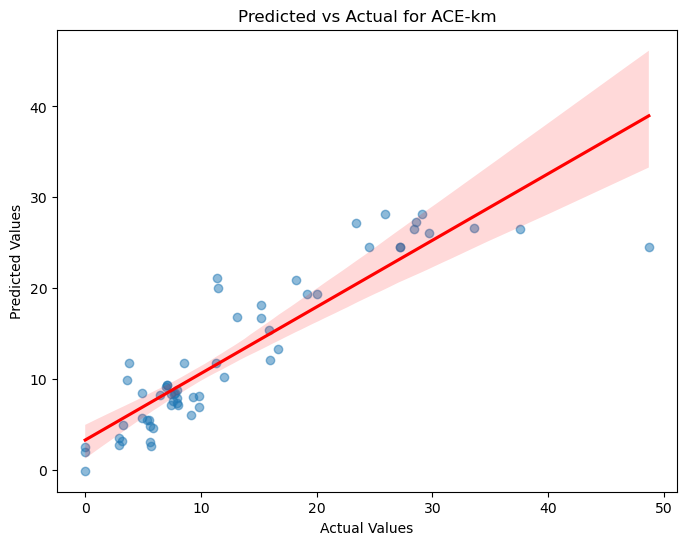

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset from DataFrame
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Cross-validation function
def cross_validate(df, target_column, k_folds=5, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k_folds}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                val_preds.extend(predictions)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        print(f"Fold {fold+1}: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"Final Cross-Validation Results: MSE = {np.mean(mse_scores):.4f}, R^2 = {np.mean(r2_scores):.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform cross-validation for a target column
target_column = "ACE-km"
cross_validate(df, target_column)


### LOGO


LOGO Fold 1/18: Excluding Digester Group 0


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200], Loss: 274.0208
Epoch [2/200], Loss: 176.3845
Epoch [3/200], Loss: 182.1474
Epoch [4/200], Loss: 152.6469
Epoch [5/200], Loss: 171.5730
Epoch [6/200], Loss: 151.7819
Epoch [7/200], Loss: 160.2554
Epoch [8/200], Loss: 158.0627
Epoch [9/200], Loss: 149.6841
Epoch [10/200], Loss: 138.1664
Epoch [11/200], Loss: 129.4156
Epoch [12/200], Loss: 120.5059
Epoch [13/200], Loss: 143.3707
Epoch [14/200], Loss: 131.0015
Epoch [15/200], Loss: 134.7587
Epoch [16/200], Loss: 130.6476
Epoch [17/200], Loss: 123.3188
Epoch [18/200], Loss: 131.4559
Epoch [19/200], Loss: 126.0245
Epoch [20/200], Loss: 131.8539
Epoch [21/200], Loss: 118.5525
Epoch [22/200], Loss: 107.3596
Epoch [23/200], Loss: 112.7438
Epoch [24/200], Loss: 102.2396
Epoch [25/200], Loss: 115.9364
Epoch [26/200], Loss: 109.2756
Epoch [27/200], Loss: 118.8904
Epoch [28/200], Loss: 103.7401
Epoch [29/200], Loss: 112.1518
Epoch [30/200], Loss: 105.4932
Epoch [31/200], Loss: 102.2486
Epoch [32/200], Loss: 110.4299
Epoch [33/200], L

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/200], Loss: 138.7666
Epoch [8/200], Loss: 130.5925
Epoch [9/200], Loss: 159.6890
Epoch [10/200], Loss: 128.0217
Epoch [11/200], Loss: 133.5487
Epoch [12/200], Loss: 151.0818
Epoch [13/200], Loss: 117.0131
Epoch [14/200], Loss: 127.4824
Epoch [15/200], Loss: 129.6968
Epoch [16/200], Loss: 136.0831
Epoch [17/200], Loss: 122.6527
Epoch [18/200], Loss: 117.5700
Epoch [19/200], Loss: 118.7072
Epoch [20/200], Loss: 116.1406
Epoch [21/200], Loss: 130.3233
Epoch [22/200], Loss: 134.6403
Epoch [23/200], Loss: 112.1883
Epoch [24/200], Loss: 118.7582
Epoch [25/200], Loss: 121.0535
Epoch [26/200], Loss: 112.6610
Epoch [27/200], Loss: 125.2717
Epoch [28/200], Loss: 106.7731
Epoch [29/200], Loss: 108.0427
Epoch [30/200], Loss: 113.1635
Epoch [31/200], Loss: 111.9594
Epoch [32/200], Loss: 112.0232
Epoch [33/200], Loss: 119.5640
Epoch [34/200], Loss: 107.2174
Epoch [35/200], Loss: 98.8305
Epoch [36/200], Loss: 122.7919
Epoch [37/200], Loss: 115.7151
Epoch [38/200], Loss: 115.1299
Epoch [39/20

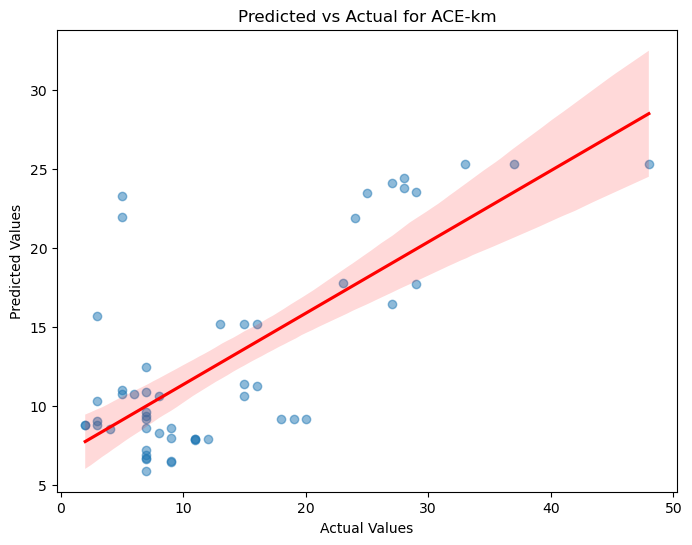

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_CB", "Digester_CP", "Digester_FD",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# "Digester_BF", "Digester_GB",

# Identify digester group columns
digester_columns = [col for col in target_columns if col.startswith("Digester_")]

# Load dataset and extract groups
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Extract digester groups by finding the highest one-hot encoded value
    digester_groups = df[digester_columns].idxmax(axis=1)  # Assign group based on max index
    
    # Convert group names to numerical indices
    unique_groups = {name: idx for idx, name in enumerate(digester_groups.unique())}
    digester_groups = digester_groups.map(unique_groups)  # Convert to numerical labels

    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    return X, y, digester_groups.values

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=32, num_layers=4, dim_feedforward=512, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Leave-One-Group-Out Cross-Validation (LOGO)
def leave_one_group_out_cv(df, target_column, epochs=200):
    X, y, groups = prepare_data(df, target_column)
    logo = LeaveOneGroupOut()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_actuals, all_predictions = [], []  # Collect all validation points

    for fold, (train_idx, val_idx) in enumerate(logo.split(X, y, groups)):
        print(f"\nLOGO Fold {fold+1}/{len(np.unique(groups))}: Excluding Digester Group {groups[val_idx][0]}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                all_predictions.extend(predictions)  # Collect all validation predictions
                all_actuals.extend(y_batch.cpu().numpy())  # Collect all validation true values

        print(f"LOGO Fold {fold+1} completed.")

    # Calculate MSE and R² only after all folds are processed
    mse = mean_squared_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)

    print(f"\nFinal LOGO-CV Results: MSE = {mse:.4f}, R² = {r2:.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform LOGO-CV for a target column
target_column = "ACE-km"
leave_one_group_out_cv(df_use, target_column)

## Different Model achitectures

In [11]:
import torch
import torch.nn as nn

class TabTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, 
                 dim_feedforward=256, dropout=0.1):
        """
        Args:
            input_dim (int): The number of features (each treated as a token).
            d_model (int): The embedding dimension for each token.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network inside transformer layers.
            dropout (float): Dropout rate.
        """
        super(TabTransformerRegression, self).__init__()
        self.num_features = input_dim
        self.feature_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(input_dim, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, input_dim)
        """
        batch_size, num_features = x.size()
        
        x = x.unsqueeze(-1)
        x = self.feature_proj(x)
        x = x + self.pos_embedding.unsqueeze(0)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)

import torch
import torch.nn as nn

class LightweightTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=1, dim_feedforward=128, dropout=0.1):
        super(LightweightTransformerRegression, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)


class MidLevelTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        """
        Args:
            input_dim (int): Number of features per sample.
            d_model (int): Embedding dimension for each feature token.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network inside transformer layers.
            dropout (float): Dropout rate.
        """
        super(MidLevelTransformerRegression, self).__init__()
        self.num_features = input_dim
        self.feature_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(input_dim, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, input_dim)
        Returns:
            Tensor of shape (batch_size,) with regression predictions.
        """
        batch_size, num_features = x.size()
        x = x.unsqueeze(-1)
        x = self.feature_proj(x)
        x = x + self.pos_embedding.unsqueeze(0)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)


## Complex Model

### No CV

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the Transformer model
class TabularTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        
        self.feature_embedding = nn.Linear(1, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 32),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x_emb = self.feature_embedding(x.unsqueeze(-1))
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x_emb], dim=1)
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.regressor(cls_output).squeeze()

# Dataset preparation functions
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, scaler

class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    best_loss = float('inf')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val).item() * X_val.size(0)
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    
    print('Training complete')
    model.load_state_dict(torch.load('best_model.pth'))
    return model

# Main execution
if __name__ == "__main__":
    # Load your data
    df_use = pd.read_csv('Data/New_data.csv')  # Replace with your data loading
    
    # Prepare data
    target_column = "ACE-km"
    X, y, scaler = prepare_data(df_use, target_column)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = MicrobialDataset(X_train, y_train)
    val_dataset = MicrobialDataset(X_val, y_val)
    
    # Create dataloaders
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model
    num_features = X_train.shape[1]
    model = TabularTransformer(
        num_features=num_features,
        d_model=64,
        nhead=4,
        num_layers=2,
        dropout=0.2
    )
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # Train the model
    trained_model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=50
    )
    
    # Evaluation
    trained_model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        predictions = trained_model(X_val_tensor).cpu().numpy()
        
        # Calculate metrics
        mse = np.mean((predictions - y_val) ** 2)
        mae = np.mean(np.abs(predictions - y_val))
        print(f'\nFinal Validation Metrics:')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')
        print(f'RMSE: {np.sqrt(mse):.4f}')

Epoch 1/50 - Train Loss: 293.3357 - Val Loss: 189.9779
Epoch 2/50 - Train Loss: 274.7399 - Val Loss: 178.2214
Epoch 3/50 - Train Loss: 262.5762 - Val Loss: 169.2988
Epoch 4/50 - Train Loss: 250.3853 - Val Loss: 161.5754
Epoch 5/50 - Train Loss: 248.8328 - Val Loss: 154.2256
Epoch 6/50 - Train Loss: 238.9467 - Val Loss: 147.1032
Epoch 7/50 - Train Loss: 228.5577 - Val Loss: 139.9063
Epoch 8/50 - Train Loss: 226.3169 - Val Loss: 133.2458
Epoch 9/50 - Train Loss: 218.5774 - Val Loss: 127.2677
Epoch 10/50 - Train Loss: 211.8984 - Val Loss: 122.1929
Epoch 11/50 - Train Loss: 201.6307 - Val Loss: 117.5137
Epoch 12/50 - Train Loss: 194.0761 - Val Loss: 113.2108
Epoch 13/50 - Train Loss: 194.9467 - Val Loss: 109.3189
Epoch 14/50 - Train Loss: 186.8673 - Val Loss: 105.7894
Epoch 15/50 - Train Loss: 182.3045 - Val Loss: 102.3608
Epoch 16/50 - Train Loss: 174.3950 - Val Loss: 98.8562
Epoch 17/50 - Train Loss: 174.4861 - Val Loss: 95.8380
Epoch 18/50 - Train Loss: 177.2390 - Val Loss: 93.3505
Epoc

### LOGO


LOGO Fold 1/18: Excluding Digester Group 0
Epoch 1/50 - Train Loss: 295.6415 - Val Loss: 9.1222
Epoch 2/50 - Train Loss: 295.8872 - Val Loss: 4.9212
Epoch 3/50 - Train Loss: 263.4765 - Val Loss: 2.2790
Epoch 4/50 - Train Loss: 243.6227 - Val Loss: 0.9045
Epoch 5/50 - Train Loss: 243.6521 - Val Loss: 0.2464
Epoch 6/50 - Train Loss: 211.3891 - Val Loss: 0.0266
Epoch 7/50 - Train Loss: 224.1974 - Val Loss: 0.0915
Epoch 8/50 - Train Loss: 213.3746 - Val Loss: 0.3808
Epoch 9/50 - Train Loss: 210.2859 - Val Loss: 0.9115
Epoch 10/50 - Train Loss: 196.3162 - Val Loss: 1.7091
Epoch 11/50 - Train Loss: 208.2766 - Val Loss: 2.8015
Epoch 12/50 - Train Loss: 199.7261 - Val Loss: 4.2411
Epoch 13/50 - Train Loss: 192.5031 - Val Loss: 4.4011
Epoch 14/50 - Train Loss: 190.2002 - Val Loss: 4.5626
Epoch 15/50 - Train Loss: 174.0821 - Val Loss: 4.7319
Epoch 16/50 - Train Loss: 195.4641 - Val Loss: 4.9070
Early stopping at epoch 16
LOGO Fold 1 completed.

LOGO Fold 2/18: Excluding Digester Group 1
Epoch 1

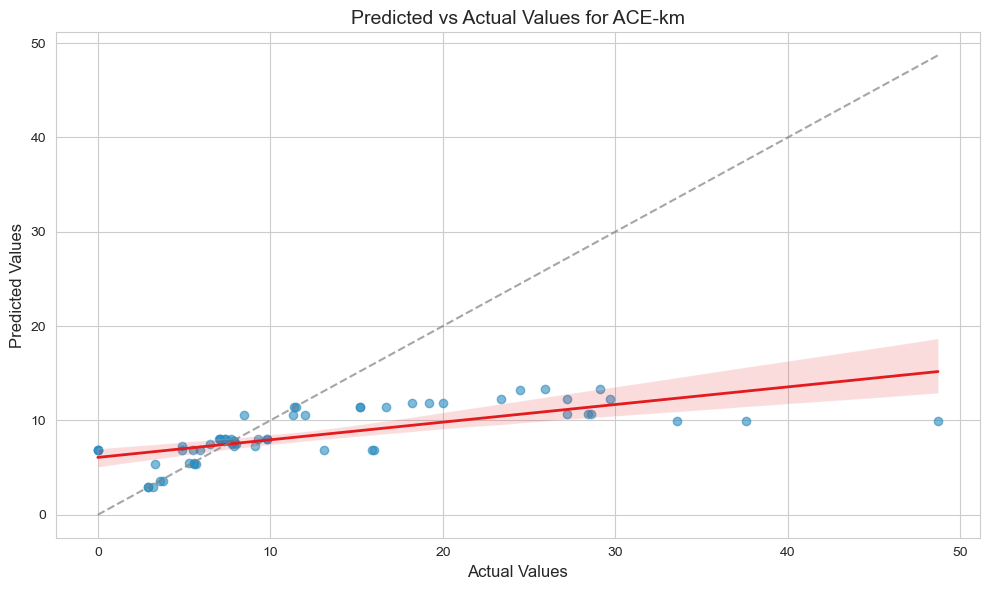

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_CB", "Digester_CP", "Digester_FD",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Identify digester group columns
digester_columns = [col for col in target_columns if col.startswith("Digester_")]

# Load dataset and extract groups
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Extract digester groups by finding the highest one-hot encoded value
    digester_groups = df[digester_columns].idxmax(axis=1)
    unique_groups = {name: idx for idx, name in enumerate(digester_groups.unique())}
    digester_groups = digester_groups.map(unique_groups)

    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    # Add feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, digester_groups.values

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Enhanced Transformer Model (your architecture)
class TabularTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        
        # Feature embedding layer
        self.feature_embedding = nn.Linear(1, d_model)
        
        # Learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 32),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x_emb = self.feature_embedding(x.unsqueeze(-1))
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x_emb], dim=1)
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.regressor(cls_output).squeeze()

# Modified LOGO-CV with improved training
def leave_one_group_out_cv(df, target_column, epochs=100):
    X, y, groups = prepare_data(df, target_column)
    logo = LeaveOneGroupOut()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_actuals, all_predictions = [], []

    for fold, (train_idx, val_idx) in enumerate(logo.split(X, y, groups)):
        print(f"\nLOGO Fold {fold+1}/{len(np.unique(groups))}: Excluding Digester Group {groups[val_idx][0]}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        num_features = X_train.shape[1]
        model = TabularTransformer(
            num_features=num_features,
            d_model=64,
            nhead=4,
            num_layers=2,
            dropout=0.2
        ).to(device)
        
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        # Training loop with early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 10

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                    outputs = model(X_val_batch)
                    val_loss += criterion(outputs, y_val_batch).item()
            
            avg_train_loss = train_loss/len(train_loader)
            avg_val_loss = val_loss/len(val_loader)
            scheduler.step(avg_val_loss)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model for this fold
        model.load_state_dict(torch.load('best_model.pth'))
        
        # Final validation prediction
        model.eval()
        with torch.no_grad():
            val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            fold_preds = model(val_tensor).cpu().numpy()
            all_predictions.extend(fold_preds)
            all_actuals.extend(y_val)

        print(f"LOGO Fold {fold+1} completed.")

    # Calculate final metrics
    mse = mean_squared_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(np.array(all_actuals) - np.array(all_predictions)))

    print(f"\nFinal LOGO-CV Metrics for {target_column}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    # Enhanced visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    ax = sns.regplot(x=all_actuals, y=all_predictions, 
                    scatter_kws={'alpha':0.6, 'color':'#2b8cbe'}, 
                    line_kws={'color':'#e41a1c', 'lw':2})
    
    ax.plot([min(all_actuals), max(all_actuals)], 
            [min(all_actuals), max(all_actuals)], 
            '--', color='gray', alpha=0.7)
    
    plt.title(f"Predicted vs Actual Values for {target_column}", fontsize=14)
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load your dataset
    df_use = pd.read_csv("Data/New_data.csv")  # Update with your actual path
    
    # Run LOGO-CV for target column
    target_column = "ACE-km"
    leave_one_group_out_cv(df_use, target_column, epochs=100)

### 5-Fold CV


Fold 1/5
Epoch 1/100 - Train Loss: 288.6538 - Val Loss: 199.3862
Epoch 2/100 - Train Loss: 280.9319 - Val Loss: 190.0163
Epoch 3/100 - Train Loss: 273.6458 - Val Loss: 181.2045
Epoch 4/100 - Train Loss: 269.1305 - Val Loss: 173.1799
Epoch 5/100 - Train Loss: 255.4209 - Val Loss: 165.6258
Epoch 6/100 - Train Loss: 256.8691 - Val Loss: 158.6141
Epoch 7/100 - Train Loss: 245.9008 - Val Loss: 152.1739
Epoch 8/100 - Train Loss: 234.5455 - Val Loss: 146.0296
Epoch 9/100 - Train Loss: 229.6543 - Val Loss: 139.8458
Epoch 10/100 - Train Loss: 228.1484 - Val Loss: 133.8368
Epoch 11/100 - Train Loss: 211.1736 - Val Loss: 128.3446
Epoch 12/100 - Train Loss: 205.1974 - Val Loss: 123.2065
Epoch 13/100 - Train Loss: 202.1957 - Val Loss: 118.4722
Epoch 14/100 - Train Loss: 202.9127 - Val Loss: 114.2863
Epoch 15/100 - Train Loss: 198.1690 - Val Loss: 110.3274
Epoch 16/100 - Train Loss: 195.3354 - Val Loss: 106.6278
Epoch 17/100 - Train Loss: 189.8399 - Val Loss: 103.1698
Epoch 18/100 - Train Loss: 181

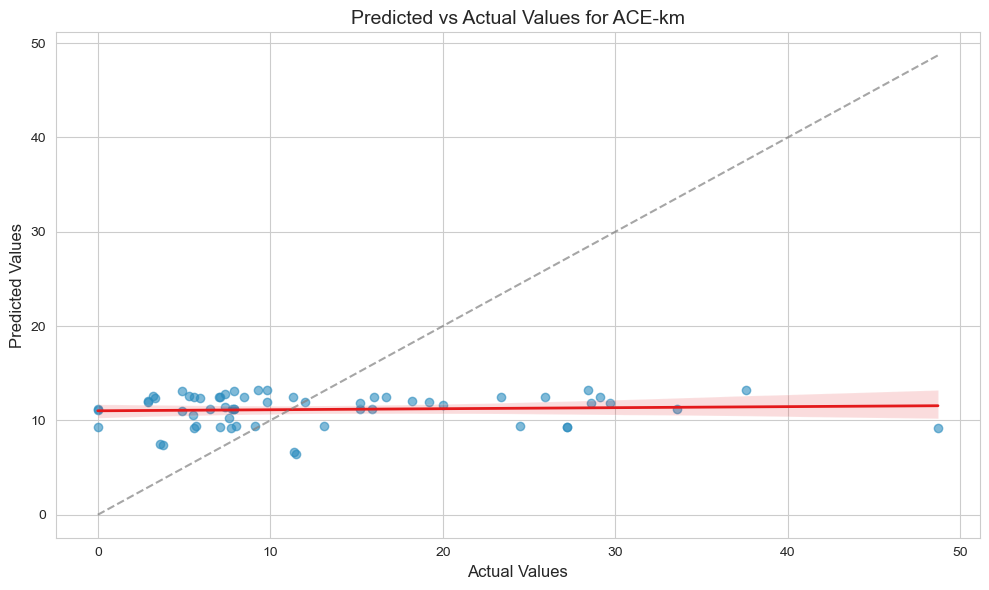

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_CB", "Digester_CP", "Digester_FD",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset and prepare features
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer Model (same as before)
class TabularTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        
        self.feature_embedding = nn.Linear(1, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 32),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x_emb = self.feature_embedding(x.unsqueeze(-1))
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x_emb], dim=1)
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.regressor(cls_output).squeeze()

# Modified 5-fold CV training
def five_fold_cv(df, target_column, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_actuals, all_predictions = [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/5")
        
        # Scale features within fold to prevent data leakage
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X[train_idx])
        X_val = scaler.transform(X[val_idx])
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        num_features = X_train.shape[1]
        model = TabularTransformer(
            num_features=num_features,
            d_model=64,
            nhead=4,
            num_layers=2,
            dropout=0.2
        ).to(device)
        
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        # Training loop with early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 10

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                    outputs = model(X_val_batch)
                    val_loss += criterion(outputs, y_val_batch).item()
            
            avg_train_loss = train_loss/len(train_loader)
            avg_val_loss = val_loss/len(val_loader)
            scheduler.step(avg_val_loss)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model for this fold
        model.load_state_dict(torch.load('best_model.pth'))
        
        # Final validation prediction
        model.eval()
        with torch.no_grad():
            val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            fold_preds = model(val_tensor).cpu().numpy()
            all_predictions.extend(fold_preds)
            all_actuals.extend(y_val)

        print(f"Fold {fold+1} completed.")

    # Calculate final metrics
    mse = mean_squared_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(np.array(all_actuals) - np.array(all_predictions)))

    print(f"\nFinal 5-Fold CV Metrics for {target_column}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    ax = sns.regplot(x=all_actuals, y=all_predictions, 
                    scatter_kws={'alpha':0.6, 'color':'#2b8cbe'}, 
                    line_kws={'color':'#e41a1c', 'lw':2})
    
    ax.plot([min(all_actuals), max(all_actuals)], 
            [min(all_actuals), max(all_actuals)], 
            '--', color='gray', alpha=0.7)
    
    plt.title(f"Predicted vs Actual Values for {target_column}", fontsize=14)
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load your dataset
    df_use = pd.read_csv("Data/New_data.csv")  # Update with your actual path
    
    # Run 5-fold CV for target column
    target_column = "ACE-km"
    five_fold_cv(df_use, target_column, epochs=100)

## TabTransfromer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

###############################################
# 1. Define a Dataset that Processes the Data #
###############################################

class TabularDataset(Dataset):
    """
    A dataset that accepts a DataFrame and separates numerical and categorical features.
    The numerical features are scaled, and the categorical features are label-encoded.
    Optionally, you can pass an already fitted scaler and encoders (useful for validation data).
    """
    def __init__(self, df, cat_cols, num_cols, target_col, scaler=None, cat_encoders=None):
        self.df = df.copy().dropna().reset_index(drop=True)
        self.df = self.df.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col

        if scaler is None:
            self.scaler = StandardScaler()
            self.num_data = self.scaler.fit_transform(self.df[num_cols])
        else:
            self.scaler = scaler
            self.num_data = self.scaler.transform(self.df[num_cols])
        
        cat_data_list = []
        for col in cat_cols:
            if cat_encoders is None or col not in cat_encoders:
                le = LabelEncoder()
                encoded = le.fit_transform(self.df[col])
                self.cat_encoders[col] = le
            else:
                le = cat_encoders[col]
                self.cat_encoders[col] = le
                encoded = le.transform(self.df[col])
            cat_data_list.append(encoded.astype(np.int64))
        if len(cat_cols) > 0:
            self.cat_data = np.stack(cat_data_list, axis=1)
        else:
            self.cat_data = None
        
        self.target = self.df[target_col].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        num = self.num_data[idx]
        if self.cat_data is not None:
            cat = self.cat_data[idx]
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(cat, dtype=torch.long),
                    torch.tensor(self.target[idx], dtype=torch.float32))
        else:
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(self.target[idx], dtype=torch.float32))

###########################################################
# 2. Define the TabTransformer Model for Regression Tasks #
###########################################################

class TabTransformerModel(nn.Module):
    """
    Transformer-based model for tabular regression.
    It embeds categorical features and projects numerical features into a common embedding space,
    concatenates them, and passes the combined vector through a transformer encoder and regression head.
    """
    def __init__(self, num_features, cat_cardinalities, embed_dim=32, nhead=4, num_transformer_layers=2,
                 dim_feedforward=64, dropout=0.1):
        super(TabTransformerModel, self).__init__()
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=card, embedding_dim=embed_dim)
            for card in cat_cardinalities
        ])
        self.num_proj = nn.Linear(num_features, embed_dim)
        
        self.num_tokens = 1 + len(cat_cardinalities)
        self.transformer_input_dim = self.num_tokens * embed_dim
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.transformer_input_dim,
            nhead=nhead,
            dropout=dropout,
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        
        # Regression head
        self.fc = nn.Sequential(
            nn.Linear(self.transformer_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, num_data, cat_data):
        num_embed = self.num_proj(num_data)
        
        if cat_data is not None:
            cat_embeds = [emb(cat_data[:, i]) for i, emb in enumerate(self.cat_embeddings)]
            tokens = [num_embed] + cat_embeds
        else:
            tokens = [num_embed]
        
        tokens = torch.stack(tokens, dim=1)
        batch_size = tokens.size(0)
        tokens = tokens.view(batch_size, -1)
        tokens = tokens.unsqueeze(0)
        transformer_out = self.transformer_encoder(tokens)
        transformer_out = transformer_out.squeeze(0)
        output = self.fc(transformer_out)
        return output.squeeze(1)

##################################################
# 3. Cross-Validation with the TabTransformer Model #
##################################################

def cross_validate(df, target_column, cat_cols, num_cols, k_folds=5, epochs=100, batch_size=32, learning_rate=0.001):
    """
    Splits the DataFrame into training/validation folds.
    For each fold, fits the dataset (with scaling and encoding on training data) and trains the transformer.
    Reports MSE and R^2 for each fold and plots the overall predicted vs. actual values.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\nFold {fold+1}/{k_folds}")
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_val = df.iloc[val_idx].reset_index(drop=True)
        
        train_dataset = TabularDataset(df_train, cat_cols, num_cols, target_column)

        val_dataset = TabularDataset(df_val, cat_cols, num_cols, target_column,
                                     scaler=train_dataset.scaler, cat_encoders=train_dataset.cat_encoders)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        cat_cardinalities = []
        for col in cat_cols:
            cardinality = len(train_dataset.cat_encoders[col].classes_)
            cat_cardinalities.append(cardinality)
        
        input_dim = len(num_cols)
        model = TabTransformerModel(num_features=input_dim, cat_cardinalities=cat_cardinalities).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop
        model.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in train_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, X_cat)
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, None)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")
        
        # Validation loop
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for batch in val_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    preds = model(X_num, X_cat).cpu().numpy()
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    preds = model(X_num, None).cpu().numpy()
                val_preds.extend(preds)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        
        print(f"Fold {fold+1} Results: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"\nFinal Cross-Validation Results: Mean MSE = {np.mean(mse_scores):.4f}, Mean R^2 = {np.mean(r2_scores):.4f}")
    
    # Plot overall predicted vs. actual values
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

##############################################
# 4. Load Data and Run Cross-Validation        #
##############################################

df = pd.read_csv("Data/New_data.csv")
target_column = "ACE-km"

cat_cols = []
num_cols = [col for col in df.columns if col not in target_columns]
cross_validate(df, target_column, cat_cols, num_cols, k_folds=5, epochs=50, batch_size=32, learning_rate=0.001)